# Machine Learning

The objective of this segment of the exercise is to utilize the data prepared using the Feature Engineering methods to identify & run multiple machine learning algorithms and select the highest accuracy model to predict the winner of the 2022 Soccer World Cup.

## Import Libraries

In [365]:
import pandas as pd 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Data Preparation

The project uses five datasets:

1. world_cup_matches.csv => This is a table of every match that has been played in the World Cup from 1930 to 2014
2. international_matches.csv => This is a table of international soccer matches since 1872.
3. world_cups.csv => This is a table of some extra information about the World Cups including number of teams, qualified teams, goals scored, etc.
4. 2022_world_cup_groups.csv => This is a table of the current groups for the 2022 World Cup.
5. 2022_world_cup_matches.csv => This is a table of the scheduled matches for the 2022 World Cup.

Read data and setup titles

In [366]:
wcm = pd.read_csv('world_cup_matches.csv')
im = pd.read_csv('international_matches.csv')
wc = pd.read_csv('world_cups.csv')
ranking=pd.read_csv('2022_world_cup_groups.csv')
qatar_matches=pd.read_csv('2022_world_cup_matches.csv')

wcm.rename(lambda x: x.lower().strip().replace(' ', '_'), axis='columns', inplace=True)
im.rename(lambda x: x.lower().strip().replace(' ', '_'), axis='columns', inplace=True)
wc.rename(lambda x: x.lower().strip().replace(' ', '_'), axis='columns', inplace=True)
ranking.rename(lambda x: x.lower().strip().replace(' ', '_'), axis='columns', inplace=True)
qatar_matches.rename(lambda x: x.lower().strip().replace(' ', '_'), axis='columns', inplace=True)

In [367]:
wcm.head(3)

,id,year,date,stage,home_team,home_goals,away_goals,away_team,winning_team,losing_team,win_conditions,host_team
0,1,1930,1930/7/13,Group stage,France,4,1,Mexico,France,Mexico,NaN,False
1,2,1930,1930/7/13,Group stage,United States,3,0,Belgium,United States,Belgium,NaN,False
2,3,1930,1930/7/14,Group stage,Yugoslavia,2,1,Brazil,Yugoslavia,Brazil,NaN,False


In [368]:
im.head(3)

,id,tournament,date,home_team,home_goals,away_goals,away_team,winning_team,losing_team,win_conditions,home_stadium
0,1,Friendly,1872-11-30,Scotland,0,0,England,NaN,NaN,NaN,True
1,2,Friendly,1873-03-08,England,4,2,Scotland,England,Scotland,NaN,True
2,3,Friendly,1874-03-07,Scotland,2,1,England,Scotland,England,NaN,True


In [369]:
wc.head(3)

,year,host_country,winner,runners-up,third,fourth,goals_scored,qualified_teams,matches_played
0,1930,Uruguay,Uruguay,Argentina,USA,Yugoslavia,70.0,13,18
1,1934,Italy,Italy,Czechoslovakia,Germany,Austria,70.0,16,17
2,1938,France,Italy,Hungary,Brazil,Sweden,84.0,15,18


In [370]:
ranking.head(3)

,group,team,fifa_ranking
0,A,Qatar,50
1,A,Ecuador,44
2,A,Senegal,18


In [371]:
qatar_matches.head(3)

,id,year,date,stage,home_team,away_team,host_team
0,1,2022,2022/11/20,Group stage,Qatar,Ecuador,True
1,2,2022,2022/11/21,Group stage,Senegal,Netherlands,False
2,3,2022,2022/11/21,Group stage,England,Iran,False


In [372]:
wcm.dtypes

id                 int64
year               int64
date              object
stage             object
home_team         object
home_goals         int64
away_goals         int64
away_team         object
winning_team      object
losing_team       object
win_conditions    object
host_team           bool
dtype: object

In [373]:
im.dtypes

id                 int64
tournament        object
date              object
home_team         object
home_goals         int64
away_goals         int64
away_team         object
winning_team      object
losing_team       object
win_conditions    object
home_stadium        bool
dtype: object

In [374]:
wc.dtypes

year                 int64
host_country        object
winner              object
runners-up          object
third               object
fourth              object
goals_scored       float64
qualified_teams      int64
matches_played       int64
dtype: object

In [375]:
ranking.dtypes

group           object
team            object
fifa_ranking     int64
dtype: object

In [376]:
qatar_matches.dtypes

id            int64
year          int64
date         object
stage        object
home_team    object
away_team    object
host_team    object
dtype: object

## Create new dataframes

Create dataframe named "matches" concatening wc and im

In [377]:
col=['date', 'home_team', 'home_goals', 'away_goals',
       'away_team']

im_df=im[col]
im_df['wcm']=0
wcm_df=wcm[col]
wcm_df['wcm']=1

matches=pd.concat([im_df, wcm_df])
matches=matches.reset_index()

for i in tqdm(range(len(matches))):
    matches.loc[i,'year']=matches.date[i][:4]
matches['year']=matches['year'].astype(int)

matches=matches.drop(['index','date'], axis=1)
       
matches=matches[matches['year']>=1930]

100%|██████████████████████████████████| 18669/18669 [00:00<00:00, 26360.71it/s]


In [378]:
matches=matches.reset_index()

### Create new variable status
 - #1 for win
 - #2 for tie
 - #3 for loss

In [379]:
conditionlist = [
    (matches['home_goals']-matches['away_goals'] > 0) ,
    (matches['home_goals']-matches['away_goals'] < 0),
    (matches['home_goals']-matches['away_goals'] == 0)]
choicelist = [1, 3, 2]
matches['status'] = np.select(conditionlist, choicelist, default='Not Specified')
print(matches.shape)
matches.head(3)

(17812, 8)


,index,home_team,home_goals,away_goals,away_team,wcm,year,status
0,857,Spain,1,0,Czechoslovakia,0,1930,1
1,858,Portugal,1,0,Czechoslovakia,0,1930,1
2,859,Northern Ireland,7,0,Wales,0,1930,1


### Create dataframes "countries": Teams attribute table

Once we have the countries table completed, we'll build the dataset that has the matches.

In [380]:
xim=im['home_team']
yim=im['away_team']
countries_im=list(np.union1d(xim, yim))

xwcm=wcm['home_team']
ywcm=wcm['away_team']
countries_wcm=list(np.union1d(xwcm, ywcm))

countries_l=list(np.union1d(countries_im, countries_wcm))
countries=pd.DataFrame(countries_l)
countries.index=countries_l
countries=countries.drop(0, axis=1)

countries.head(3)

""
Afghanistan
Albania
Algeria


In [381]:
#INTERNATIONAL MATCHES
#Add total international matches played
for i in list(countries.index):
    countries.loc[i,'inter_match']=len(im[(im['home_team']==i)|(im['away_team']==i)])
   
#Add won matches
for i in list(countries.index):
    countries.loc[i,'inter_match_won']=len(im[((im['home_team']==i)&(im['home_goals']>im['away_goals']))|((im['away_team']==i)&(im['home_goals']<im['away_goals']))])

#Add lost matches
for i in list(countries.index):
    countries.loc[i,'inter_match_lost']=len(im[((im['home_team']==i)&(im['home_goals']<im['away_goals']))|((im['away_team']==i)&(im['home_goals']>im['away_goals']))])

#Add tied matches
for i in list(countries.index):
    countries.loc[i,'inter_match_tied']=len(im[((im['home_team']==i)&(im['home_goals']==im['away_goals']))|((im['away_team']==i)&(im['home_goals']==im['away_goals']))])

In [382]:
#Add scored and received goals in international matches

#Scored Goals
for i in list(countries.index):
    countries.loc[i,'inter_goals_sco']=im.loc[im['home_team']==i,'home_goals'].sum() + im.loc[im['away_team']==i,'away_goals'].sum()

#Conceded Goals
for i in list(countries.index):
    countries.loc[i,'inter_goals_con']=im.loc[im['home_team']==i,'away_goals'].sum() + im.loc[im['away_team']==i,'home_goals'].sum()

In [383]:
#WORLD CUP MATCHES
#Add total international matches played
for i in list(countries.index):
    countries.loc[i,'wc_match']=len(wcm[(wcm['home_team']==i)|(wcm['away_team']==i)])
   
#Add won matches
for i in list(countries.index):
    countries.loc[i,'wc_match_won']=len(wcm[((wcm['home_team']==i)&(wcm['home_goals']>wcm['away_goals']))|((wcm['away_team']==i)&(wcm['home_goals']<wcm['away_goals']))])

#Add lost matches
for i in list(countries.index):
    countries.loc[i,'wc_match_lost']=len(wcm[((wcm['home_team']==i)&(wcm['home_goals']<wcm['away_goals']))|((wcm['away_team']==i)&(wcm['home_goals']>wcm['away_goals']))])

#Add tied matches
for i in list(countries.index):
    countries.loc[i,'wc_match_tied']=len(wcm[((wcm['home_team']==i)&(wcm['home_goals']==wcm['away_goals']))|((wcm['away_team']==i)&(wcm['home_goals']==wcm['away_goals']))])

In [384]:
#Add scored and received goals in World Cups

#Scored Goals
for i in list(countries.index):
    countries.loc[i,'wc_goals_sco']=wcm.loc[wcm['home_team']==i,'home_goals'].sum() + wcm.loc[wcm['away_team']==i,'away_goals'].sum()

#Conceded Goals
for i in list(countries.index):
    countries.loc[i,'wc_goals_con']=wcm.loc[wcm['home_team']==i,'away_goals'].sum() + wcm.loc[wcm['away_team']==i,'home_goals'].sum()

In [385]:
print(countries.shape)
countries.head(3)

(227, 12)


,inter_match,inter_match_won,inter_match_lost,inter_match_tied,inter_goals_sco,inter_goals_con,wc_match,wc_match_won,wc_match_lost,wc_match_tied,wc_goals_sco,wc_goals_con
Afghanistan,10.0,0.0,9.0,1.0,2.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0
Albania,93.0,10.0,69.0,14.0,54.0,196.0,0.0,0.0,0.0,0.0,0.0,0.0
Algeria,146.0,52.0,53.0,41.0,156.0,162.0,13.0,3.0,7.0,3.0,13.0,19.0


In [386]:
for i in tqdm(range(len(matches))):
    matches.loc[i,'dif_inter_match']=countries.loc[matches.loc[i,'home_team'],'inter_match']-\
    countries.loc[matches.loc[i,'away_team'],'inter_match']
    
    matches.loc[i,'dif_inter_match_won']=countries.loc[matches.loc[i,'home_team'],'inter_match_won']-\
    countries.loc[matches.loc[i,'away_team'],'inter_match_won']
    
    matches.loc[i,'dif_inter_match_lost']=countries.loc[matches.loc[i,'home_team'],'inter_match_lost']-\
    countries.loc[matches.loc[i,'away_team'],'inter_match_lost']

    matches.loc[i,'dif_inter_match_tie']=countries.loc[matches.loc[i,'home_team'],'inter_match_tied']-\
    countries.loc[matches.loc[i,'away_team'],'inter_match_tied']

    matches.loc[i,'dif_inter_goals_sco']=countries.loc[matches.loc[i,'home_team'],'inter_goals_sco']-\
    countries.loc[matches.loc[i,'away_team'],'inter_goals_sco']

    matches.loc[i,'dif_inter_goals_con']=countries.loc[matches.loc[i,'home_team'],'inter_goals_con']-\
    countries.loc[matches.loc[i,'away_team'],'inter_goals_con']

    matches.loc[i,'dif_wc_match']=countries.loc[matches.loc[i,'home_team'],'wc_match']-\
    countries.loc[matches.loc[i,'away_team'],'wc_match']

    matches.loc[i,'dif_wc_match_won']=countries.loc[matches.loc[i,'home_team'],'wc_match_won']-\
    countries.loc[matches.loc[i,'away_team'],'wc_match_won']

    matches.loc[i,'dif_wc_match_lost']=countries.loc[matches.loc[i,'home_team'],'wc_match_lost']-\
    countries.loc[matches.loc[i,'away_team'],'wc_match_lost']

    matches.loc[i,'dif_wc_match_tied']=countries.loc[matches.loc[i,'home_team'],'wc_match_tied']-\
    countries.loc[matches.loc[i,'away_team'],'wc_match_tied']

    matches.loc[i,'dif_wc_goals_sco']=countries.loc[matches.loc[i,'home_team'],'wc_goals_sco']-\
    countries.loc[matches.loc[i,'away_team'],'wc_goals_sco']
    
    matches.loc[i,'dif_wc_goals_con']=countries.loc[matches.loc[i,'home_team'],'wc_goals_con']-\
    countries.loc[matches.loc[i,'away_team'],'wc_goals_con']

100%|███████████████████████████████████| 17812/17812 [00:11<00:00, 1501.34it/s]


In [387]:
print(matches.shape)
matches.head(3)

(17812, 20)


,index,home_team,home_goals,away_goals,away_team,wcm,year,status,dif_inter_match,dif_inter_match_won,dif_inter_match_lost,dif_inter_match_tie,dif_inter_goals_sco,dif_inter_goals_con,dif_wc_match,dif_wc_match_won,dif_wc_match_lost,dif_wc_match_tied,dif_wc_goals_sco,dif_wc_goals_con
0,857,Spain,1,0,Czechoslovakia,0,1930,1,488.0,315.0,60.0,113.0,1061.0,346.0,33.0,19.0,4.0,10.0,55.0,27.0
1,858,Portugal,1,0,Czechoslovakia,0,1930,1,438.0,222.0,113.0,103.0,748.0,466.0,0.0,3.0,-4.0,1.0,5.0,-10.0
2,859,Northern Ireland,7,0,Wales,0,1930,1,-373.0,-164.0,-136.0,-73.0,-544.0,-409.0,8.0,2.0,4.0,2.0,9.0,19.0


### Dropping Columns

In [388]:
#matches=matches.drop(columns=['index','id','date'], axis=1)
#drop year
matches=matches[['home_team', 'home_goals', 'away_goals', 'away_team', 'wcm',
       'dif_inter_match', 'dif_inter_match_won', 'dif_inter_match_lost',
       'dif_inter_match_tie', 'dif_inter_goals_sco', 'dif_inter_goals_con',
       'dif_wc_match', 'dif_wc_match_won', 'dif_wc_match_lost',
       'dif_wc_match_tied', 'dif_wc_goals_sco', 'dif_wc_goals_con','status']]

matches.head(3)

,home_team,home_goals,away_goals,away_team,wcm,dif_inter_match,dif_inter_match_won,dif_inter_match_lost,dif_inter_match_tie,dif_inter_goals_sco,dif_inter_goals_con,dif_wc_match,dif_wc_match_won,dif_wc_match_lost,dif_wc_match_tied,dif_wc_goals_sco,dif_wc_goals_con,status
0,Spain,1,0,Czechoslovakia,0,488.0,315.0,60.0,113.0,1061.0,346.0,33.0,19.0,4.0,10.0,55.0,27.0,1
1,Portugal,1,0,Czechoslovakia,0,438.0,222.0,113.0,103.0,748.0,466.0,0.0,3.0,-4.0,1.0,5.0,-10.0,1
2,Northern Ireland,7,0,Wales,0,-373.0,-164.0,-136.0,-73.0,-544.0,-409.0,8.0,2.0,4.0,2.0,9.0,19.0,1


## Train the Classification Model

In [389]:
def Match_pred (df, model):
    for i in list(df.index):    
        df.loc[i,'dif_inter_match']=countries.loc[df.loc[i,'home_team'],'inter_match']-\
        countries.loc[df.loc[i,'away_team'],'inter_match']

        df.loc[i,'dif_inter_match_won']=countries.loc[df.loc[i,'home_team'],'inter_match_won']-\
        countries.loc[df.loc[i,'away_team'],'inter_match_won']

        df.loc[i,'dif_inter_match_lost']=countries.loc[df.loc[i,'home_team'],'inter_match_lost']-\
        countries.loc[df.loc[i,'away_team'],'inter_match_lost']

        df.loc[i,'dif_inter_match_tie']=countries.loc[df.loc[i,'home_team'],'inter_match_tied']-\
        countries.loc[df.loc[i,'away_team'],'inter_match_tied']

        df.loc[i,'dif_inter_goals_sco']=countries.loc[df.loc[i,'home_team'],'inter_goals_sco']-\
        countries.loc[df.loc[i,'away_team'],'inter_goals_sco']

        df.loc[i,'dif_inter_goals_con']=countries.loc[df.loc[i,'home_team'],'inter_goals_con']-\
        countries.loc[df.loc[i,'away_team'],'inter_goals_con']

        df.loc[i,'dif_wc_match']=countries.loc[df.loc[i,'home_team'],'wc_match']-\
        countries.loc[df.loc[i,'away_team'],'wc_match']

        df.loc[i,'dif_wc_match_won']=countries.loc[df.loc[i,'home_team'],'wc_match_won']-\
        countries.loc[df.loc[i,'away_team'],'wc_match_won']

        df.loc[i,'dif_wc_match_lost']=countries.loc[df.loc[i,'home_team'],'wc_match_lost']-\
        countries.loc[df.loc[i,'away_team'],'wc_match_lost']

        df.loc[i,'dif_wc_match_tied']=countries.loc[df.loc[i,'home_team'],'wc_match_tied']-\
        countries.loc[df.loc[i,'away_team'],'wc_match_tied']

        df.loc[i,'dif_wc_goals_sco']=countries.loc[df.loc[i,'home_team'],'wc_goals_sco']-\
        countries.loc[df.loc[i,'away_team'],'wc_goals_sco']

        df.loc[i,'dif_wc_goals_con']=countries.loc[df.loc[i,'home_team'],'wc_goals_con']-\
        countries.loc[df.loc[i,'away_team'],'wc_goals_con']

    df['wcm']=1
    df=df[['home_team', 'away_team', 'wcm',
       'dif_inter_match', 'dif_inter_match_won', 'dif_inter_match_lost',
       'dif_inter_match_tie', 'dif_inter_goals_sco', 'dif_inter_goals_con',
       'dif_wc_match', 'dif_wc_match_won', 'dif_wc_match_lost',
       'dif_wc_match_tied', 'dif_wc_goals_sco', 'dif_wc_goals_con']]
    
    X=df.drop(columns=['home_team', 'away_team'], axis=1)
    y_pred = model.predict(np.array(X))
    X['home_pred']=y_pred
    X.home_pred=X.home_pred.map({1:"Win",2:"Tie",3:"Lose"})
    
    return X.home_pred

In [390]:
stages=qatar_matches[qatar_matches['stage']=='Group stage']
stages=stages[['stage','home_team','away_team']]
stages.head(3)

,stage,home_team,away_team
0,Group stage,Qatar,Ecuador
1,Group stage,Senegal,Netherlands
2,Group stage,England,Iran


In [391]:
# Set X and y 
X=matches.drop(columns=['home_team','home_goals','away_goals', 'away_team', 'status'], axis=1)
y=matches[['status']]
y=y.astype(int)

In [392]:
#GaussianNB 
#implements the Gaussian Naive Bayes algorithm for classification. 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
#https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes

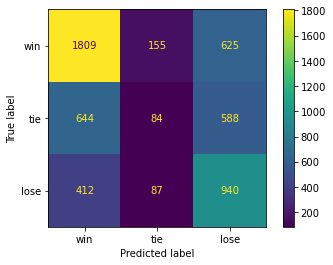

              precision    recall  f1-score   support

           1       0.63      0.70      0.66      2589
           2       0.26      0.06      0.10      1316
           3       0.44      0.65      0.52      1439

    accuracy                           0.53      5344
   macro avg       0.44      0.47      0.43      5344
weighted avg       0.49      0.53      0.49      5344



In [393]:
#Confusion matrix display
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
labels_=['win', 'tie', 'lose']
cm = confusion_matrix(y_test, y_pred, labels=gnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels_)
disp.plot()
plt.show()

from sklearn.metrics import classification_report
print((classification_report(y_test, y_pred)))

In [394]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
k = 18
KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
y_pred = KNN.predict(X_test)

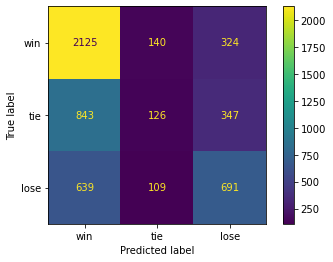

              precision    recall  f1-score   support

           1       0.59      0.82      0.69      2589
           2       0.34      0.10      0.15      1316
           3       0.51      0.48      0.49      1439

    accuracy                           0.55      5344
   macro avg       0.48      0.47      0.44      5344
weighted avg       0.50      0.55      0.50      5344



In [395]:
#Confusion matrix display
labels_=['win', 'tie', 'lose']
cm = confusion_matrix(y_test, y_pred, labels=gnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels_)
disp.plot()
plt.show()

from sklearn.metrics import classification_report
print((classification_report(y_test, y_pred)))

## Machine Learning Models

I have used 3 different models to select the most accurate one to be used for predicting the winner from group stages all the way through the final of the tournament.

1. Decision Tree
2. Logistic Regression
3. Random Forest

### Decision Tree

In [396]:
#Decision tree
from sklearn.tree import DecisionTreeClassifier
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 8).fit(X_train,y_train)
y_pred = Tree.predict(X_test)

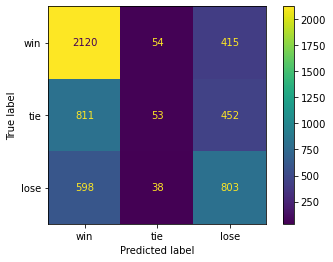

              precision    recall  f1-score   support

           1       0.60      0.82      0.69      2589
           2       0.37      0.04      0.07      1316
           3       0.48      0.56      0.52      1439

    accuracy                           0.56      5344
   macro avg       0.48      0.47      0.43      5344
weighted avg       0.51      0.56      0.49      5344



In [397]:
#Confusion matrix display
labels_=['win', 'tie', 'lose']
cm = confusion_matrix(y_test, y_pred, labels=gnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels_)
disp.plot()
plt.show()

from sklearn.metrics import classification_report
print((classification_report(y_test, y_pred)))

### Logistic Regression

In [398]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
y_pred = LR.predict(X_test)

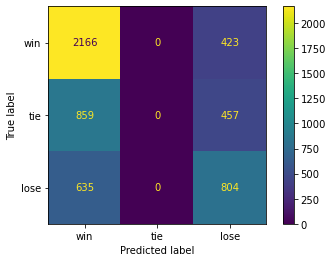

              precision    recall  f1-score   support

           1       0.59      0.84      0.69      2589
           2       0.00      0.00      0.00      1316
           3       0.48      0.56      0.51      1439

    accuracy                           0.56      5344
   macro avg       0.36      0.47      0.40      5344
weighted avg       0.42      0.56      0.47      5344



In [399]:
#Confusion matrix display
labels_=['win', 'tie', 'lose']
cm = confusion_matrix(y_test, y_pred, labels=gnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels_)
disp.plot()
plt.show()

from sklearn.metrics import classification_report
print((classification_report(y_test, y_pred)))

### Random Forest

In [400]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=7, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

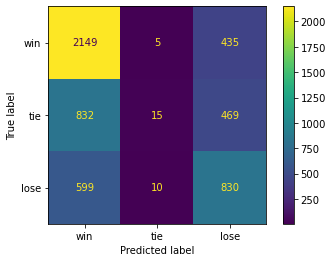

              precision    recall  f1-score   support

           1       0.60      0.83      0.70      2589
           2       0.50      0.01      0.02      1316
           3       0.48      0.58      0.52      1439

    accuracy                           0.56      5344
   macro avg       0.53      0.47      0.41      5344
weighted avg       0.54      0.56      0.48      5344



In [401]:
#Confusion matrix display
labels_=['win', 'tie', 'lose']
cm = confusion_matrix(y_test, y_pred, labels=gnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels_)
disp.plot()
plt.show()

from sklearn.metrics import classification_report
print((classification_report(y_test, y_pred)))

The best model is the Random Forest Model!

In [402]:
X

array([[   0.,  488.,  315., ...,   10.,   55.,   27.],
       [   0.,  438.,  222., ...,    1.,    5.,  -10.],
       [   0., -373., -164., ...,    2.,    9.,   19.],
       ...,
       [   1., -647., -391., ...,  -17.,  -56.,  -38.],
       [   1., -222., -231., ...,  -12.,  -23.,    8.],
       [   1.,  478.,  228., ...,    9.,   85.,   51.]])

In [403]:
X = pd.DataFrame(X,columns=['wcm','dif_inter_match', 'dif_inter_match_won', 'dif_inter_match_lost',
       'dif_inter_match_tie', 'dif_inter_goals_sco', 'dif_inter_goals_con',
       'dif_wc_match', 'dif_wc_match_won', 'dif_wc_match_lost',
       'dif_wc_match_tied', 'dif_wc_goals_sco', 'dif_wc_goals_con'])

### View Feature Important Scores

In [404]:
feature_scores = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

feature_scores

dif_wc_match_won        0.181240
dif_wc_goals_sco        0.138035
dif_wc_match            0.114324
dif_wc_match_tied       0.101364
dif_inter_match_won     0.079367
dif_wc_match_lost       0.078738
dif_inter_goals_sco     0.060003
dif_wc_goals_con        0.059923
dif_inter_match         0.059917
dif_inter_match_tie     0.058752
dif_inter_goals_con     0.032927
dif_inter_match_lost    0.031482
wcm                     0.003929
dtype: float64

### Visualize feature scores of the features

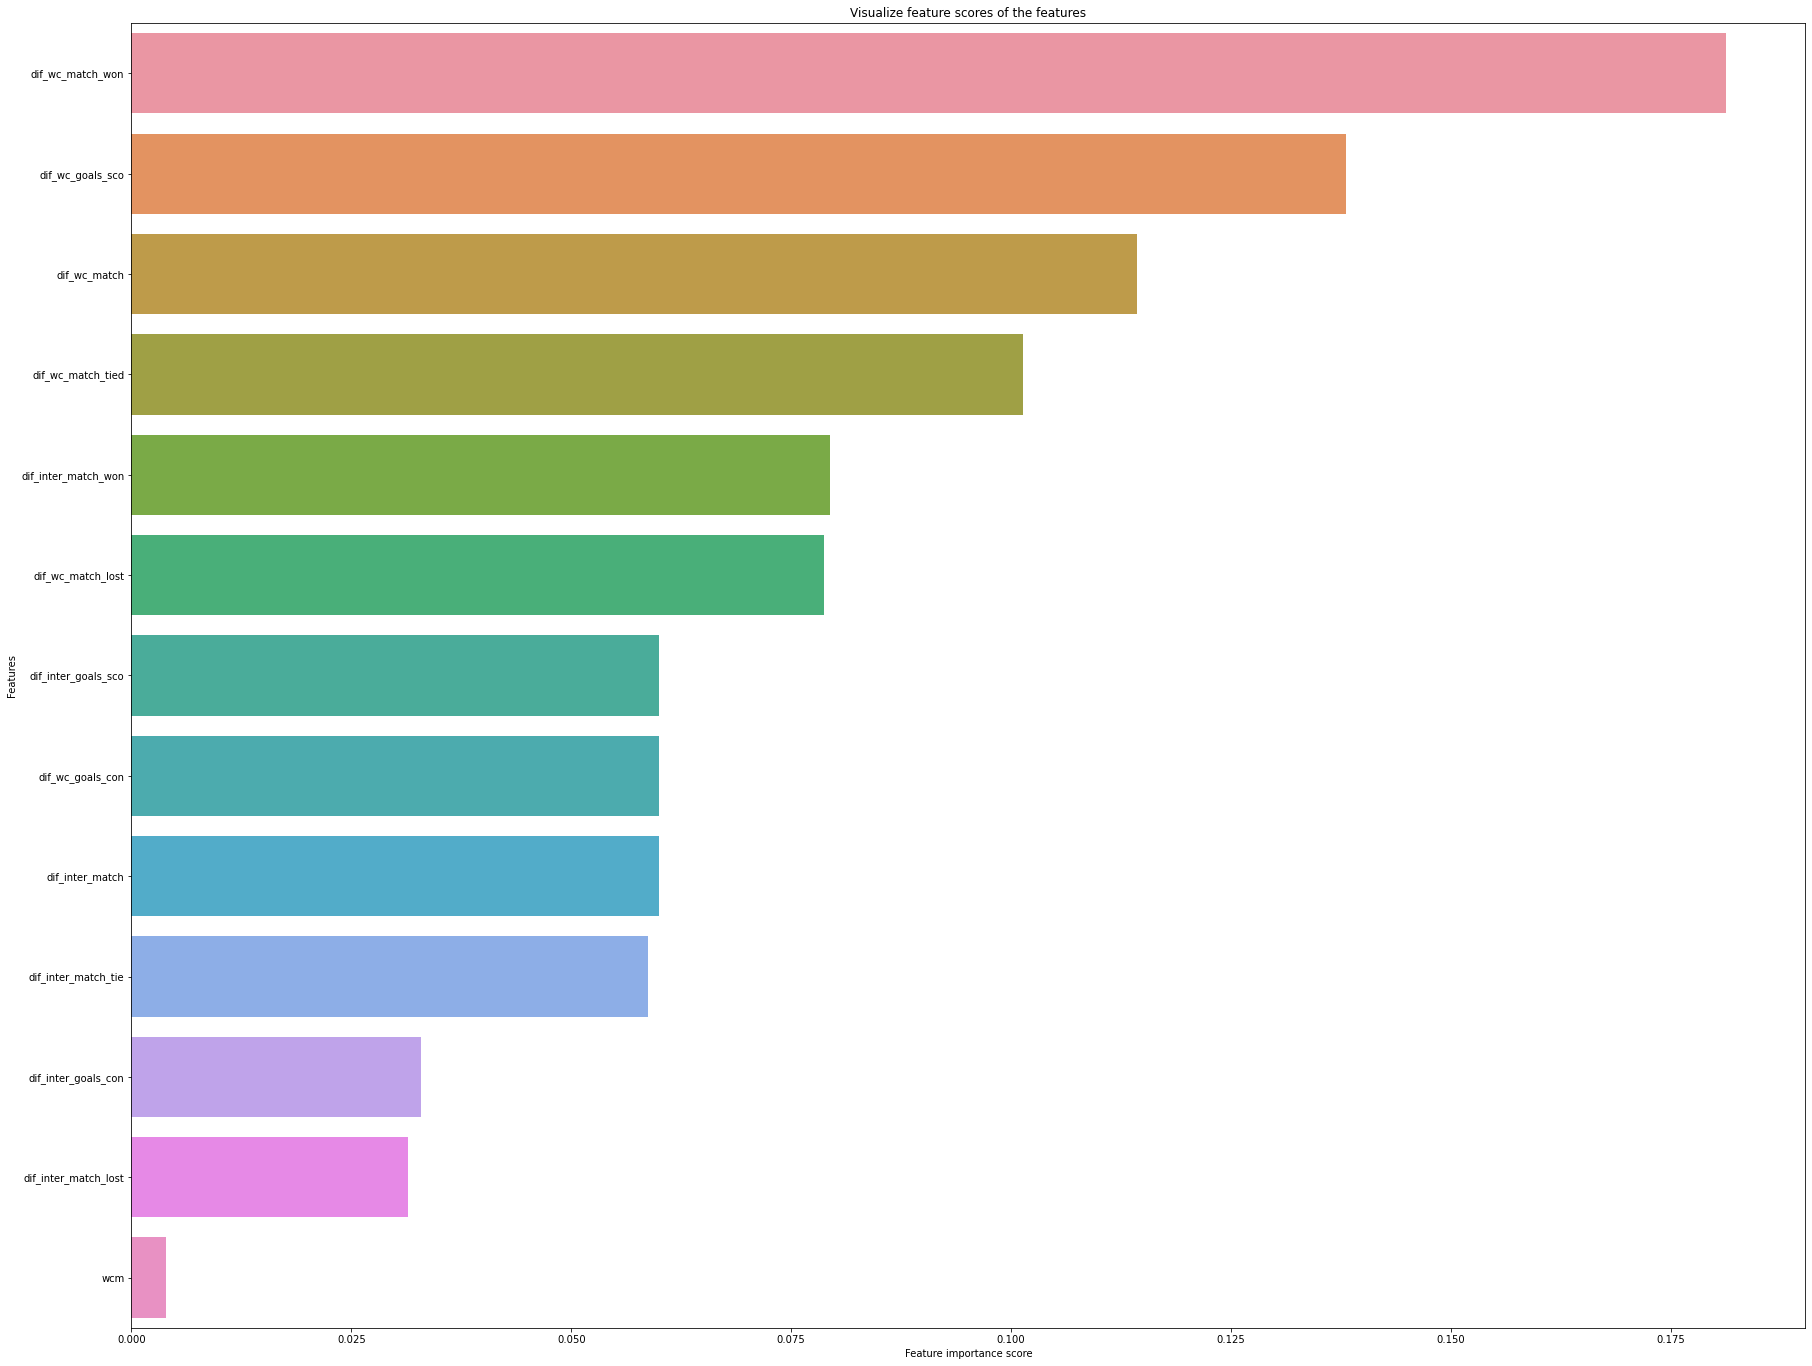

In [405]:
# Creating a seaborn bar plot

import seaborn as sns
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

dif_wc_match_won is the most important feature and wcm is the lowest.

In [406]:
X_train = pd.DataFrame(X_train,columns=['wcm','dif_inter_match', 'dif_inter_match_won', 'dif_inter_match_lost',
       'dif_inter_match_tie', 'dif_inter_goals_sco', 'dif_inter_goals_con',
       'dif_wc_match', 'dif_wc_match_won', 'dif_wc_match_lost',
       'dif_wc_match_tied', 'dif_wc_goals_sco', 'dif_wc_goals_con'])

X_test = pd.DataFrame(X_test,columns=['wcm','dif_inter_match', 'dif_inter_match_won', 'dif_inter_match_lost',
       'dif_inter_match_tie', 'dif_inter_goals_sco', 'dif_inter_goals_con',
       'dif_wc_match', 'dif_wc_match_won', 'dif_wc_match_lost',
       'dif_wc_match_tied', 'dif_wc_goals_sco', 'dif_wc_goals_con'])

### Drop WCM and Build the Random Forest model on selected features 

Rebuild the model by dropping 'wcm' feature and check its effect on precision, recall and f1-score.

In [407]:
# drop the least important feature from X_train and X_test

X_train = X_train.drop(['wcm'], axis=1)

X_test = X_test.drop(['wcm'], axis=1)

In [408]:
clf = RandomForestClassifier(max_depth=7, random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)

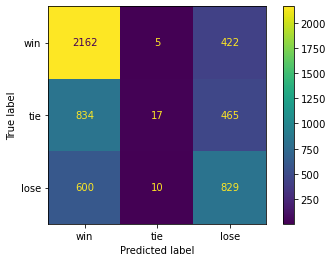

              precision    recall  f1-score   support

           1       0.60      0.84      0.70      2589
           2       0.53      0.01      0.03      1316
           3       0.48      0.58      0.53      1439

    accuracy                           0.56      5344
   macro avg       0.54      0.47      0.42      5344
weighted avg       0.55      0.56      0.49      5344



In [409]:
#Confusion matrix display
labels_=['win', 'tie', 'lose']
cm = confusion_matrix(y_test, y_pred, labels=gnb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels_)
disp.plot()
plt.show()

from sklearn.metrics import classification_report
print((classification_report(y_test, y_pred)))

Minor improvement in recall score from 0.83 to 0.84!

## Predict the winner of the World Cup

"Match_pred" function definition

In [410]:
def Match_pred (df, model):
    for i in list(df.index):    
        df.loc[i,'dif_inter_match']=countries.loc[df.loc[i,'home_team'],'inter_match']-\
        countries.loc[df.loc[i,'away_team'],'inter_match']

        df.loc[i,'dif_inter_match_won']=countries.loc[df.loc[i,'home_team'],'inter_match_won']-\
        countries.loc[df.loc[i,'away_team'],'inter_match_won']

        df.loc[i,'dif_inter_match_lost']=countries.loc[df.loc[i,'home_team'],'inter_match_lost']-\
        countries.loc[df.loc[i,'away_team'],'inter_match_lost']

        df.loc[i,'dif_inter_match_tie']=countries.loc[df.loc[i,'home_team'],'inter_match_tied']-\
        countries.loc[df.loc[i,'away_team'],'inter_match_tied']

        df.loc[i,'dif_inter_goals_sco']=countries.loc[df.loc[i,'home_team'],'inter_goals_sco']-\
        countries.loc[df.loc[i,'away_team'],'inter_goals_sco']

        df.loc[i,'dif_inter_goals_con']=countries.loc[df.loc[i,'home_team'],'inter_goals_con']-\
        countries.loc[df.loc[i,'away_team'],'inter_goals_con']

        df.loc[i,'dif_wc_match']=countries.loc[df.loc[i,'home_team'],'wc_match']-\
        countries.loc[df.loc[i,'away_team'],'wc_match']

        df.loc[i,'dif_wc_match_won']=countries.loc[df.loc[i,'home_team'],'wc_match_won']-\
        countries.loc[df.loc[i,'away_team'],'wc_match_won']

        df.loc[i,'dif_wc_match_lost']=countries.loc[df.loc[i,'home_team'],'wc_match_lost']-\
        countries.loc[df.loc[i,'away_team'],'wc_match_lost']

        df.loc[i,'dif_wc_match_tied']=countries.loc[df.loc[i,'home_team'],'wc_match_tied']-\
        countries.loc[df.loc[i,'away_team'],'wc_match_tied']

        df.loc[i,'dif_wc_goals_sco']=countries.loc[df.loc[i,'home_team'],'wc_goals_sco']-\
        countries.loc[df.loc[i,'away_team'],'wc_goals_sco']

        df.loc[i,'dif_wc_goals_con']=countries.loc[df.loc[i,'home_team'],'wc_goals_con']-\
        countries.loc[df.loc[i,'away_team'],'wc_goals_con']

        df=df[['home_team', 'away_team','dif_inter_match', 'dif_inter_match_won', 'dif_inter_match_lost',
       'dif_inter_match_tie', 'dif_inter_goals_sco', 'dif_inter_goals_con',
       'dif_wc_match', 'dif_wc_match_won', 'dif_wc_match_lost',
       'dif_wc_match_tied', 'dif_wc_goals_sco', 'dif_wc_goals_con']]
    
    X=df.drop(columns=['home_team', 'away_team'], axis=1)
    y_pred = model.predict(np.array(X))
    X['home_pred']=y_pred
    X.home_pred=X.home_pred.map({1:"Win",2:"Tie",3:"Lose"})
    
    return X.home_pred

### Stage Matches Prediction

1. #### Group stage matches prediction

In [411]:
stages=qatar_matches[qatar_matches['stage']=='Group stage']
stages=stages[['stage','home_team','away_team']]
stages.head(3)

,stage,home_team,away_team
0,Group stage,Qatar,Ecuador
1,Group stage,Senegal,Netherlands
2,Group stage,England,Iran


In [412]:
#Match predictions
y_pred=Match_pred(stages[['home_team','away_team']], clf)

In [413]:
stages['home_pred']=y_pred
#stages.home_pred=stages.home_pred.map({1:"Win",2:"Tie",3:"Lose"})
stages.head(3)

,stage,home_team,away_team,home_pred
0,Group stage,Qatar,Ecuador,Win
1,Group stage,Senegal,Netherlands,Lose
2,Group stage,England,Iran,Win


In [414]:
#Add group column to the stage group matches
ranking.index=ranking.team
group=[]
for i in stages.home_team:
    group.append(ranking.loc[i,'group'])
stages['group']=group
stages.head(3)

,stage,home_team,away_team,home_pred,group
0,Group stage,Qatar,Ecuador,Win,A
1,Group stage,Senegal,Netherlands,Lose,A
2,Group stage,England,Iran,Win,B


In [415]:
stages=stages[['group','home_team','away_team','home_pred']]
stages.head(3)

,group,home_team,away_team,home_pred
0,A,Qatar,Ecuador,Win
1,A,Senegal,Netherlands,Lose
2,B,England,Iran,Win


In [416]:
#Away prediction: opposite of home
stages['away_pred']=stages.home_pred.map({'Win':"Lose",'Tie':'Tie','Lose':'Win'})    
stages.head(3)

,group,home_team,away_team,home_pred,away_pred
0,A,Qatar,Ecuador,Win,Lose
1,A,Senegal,Netherlands,Lose,Win
2,B,England,Iran,Win,Lose


In [417]:
#Group phase 
home=stages[['home_team','home_pred']]
away=stages[['away_team','away_pred']]
home['pts']=home.home_pred.map({'Win':3,'Tie':1,'Lose':0})
away['pts']=away.away_pred.map({'Win':3,'Tie':1,'Lose':0})

#Group table
gr_tbl=ranking.drop('fifa_ranking',axis=1)

for i in list(gr_tbl.index):
    gr_tbl.loc[i,'pts']=home.loc[home['home_team']==i,'pts'].sum()+away.loc[away['away_team']==i,'pts'].sum()
    gr_tbl.loc[i,'fifa_ranking']=ranking.loc[i,'fifa_ranking']
gr_tbl=gr_tbl.sort_values(['group','pts', 'fifa_ranking'], ascending=[True,False,True])
gr_tbl.style.set_caption('Group stage finish')

,group,team,pts,fifa_ranking
team,,,,
Netherlands,A,Netherlands,9.000000,8.000000
Qatar,A,Qatar,6.000000,50.000000
Ecuador,A,Ecuador,3.000000,44.000000
Senegal,A,Senegal,0.000000,18.000000
England,B,England,9.000000,5.000000
Iran,B,Iran,6.000000,20.000000
United States,B,United States,3.000000,16.000000
Wales,B,Wales,0.000000,19.000000
Argentina,C,Argentina,9.000000,3.000000


In [418]:
#Winners of group phase
firsts=[]
seconds=[]
for g in list(gr_tbl.group.unique()):
    for n,i in enumerate(list(gr_tbl.loc[gr_tbl['group']==g,'team'])):
        if n==0:
            firsts.append(i)
        elif n==1:
            seconds.append(i)
        else:
            pass

grp_wins={"group":list(ranking['group'].unique()),
 "1":firsts,
 "2":seconds}

grp_wins=pd.DataFrame.from_dict(grp_wins)
grp_wins

,group,1,2
0,A,Netherlands,Qatar
1,B,England,Iran
2,C,Argentina,Mexico
3,D,France,Denmark
4,E,Spain,Germany
5,F,Belgium,Croatia
6,G,Brazil,Switzerland
7,H,Uruguay,South Korea


In [419]:
grp_wins['ht']=grp_wins.group.map(lambda x: str(1)+x)
grp_wins['at']=grp_wins.group.map(lambda x: str(2)+x)
grp_wins

,group,1,2,ht,at
0,A,Netherlands,Qatar,1A,2A
1,B,England,Iran,1B,2B
2,C,Argentina,Mexico,1C,2C
3,D,France,Denmark,1D,2D
4,E,Spain,Germany,1E,2E
5,F,Belgium,Croatia,1F,2F
6,G,Brazil,Switzerland,1G,2G
7,H,Uruguay,South Korea,1H,2H


In the rules of the games, when two teams are tied in points, the team who qualifies is defined by the one who has more goals, but in this model goals are not considered and so if there is a tie, the qualifier will be the one who has a better Fifa Ranking position.

2. #### Round of 16

In [420]:
#Round of 16
qatar_matches.index=qatar_matches.index+1
round_16=qatar_matches[qatar_matches.stage=='Round of 16']
round_16=round_16[['stage', 'home_team', 'away_team']]
#round_16['home_t']=home_team
#round_16['away_t']=away_team
round_16

,stage,home_team,away_team
49,Round of 16,1A,2B
50,Round of 16,1C,2D
51,Round of 16,1B,2A
52,Round of 16,1D,2C
53,Round of 16,1E,2F
54,Round of 16,1G,2H
55,Round of 16,1F,2E
56,Round of 16,1H,2G


In [421]:
import itertools
home_t=[]
away_t=[]
for i in list(round_16.index):
    home_t.append(grp_wins.loc[grp_wins['ht']==round_16.loc[i,'home_team']  , "1"].to_list())
    away_t.append(grp_wins.loc[grp_wins['at']==round_16.loc[i,'away_team']  , "2"].to_list())
home_t=list(itertools.chain(*home_t))
away_t=list(itertools.chain(*away_t))
round_16['home_t']=home_t
round_16['away_t']=away_t
round_16 = round_16.rename(columns={'home_team':'ht',
                                   'away_team':"at",
                                   'home_t':"home_team",
                                  'away_t':'away_team'})
round_16

,stage,ht,at,home_team,away_team
49,Round of 16,1A,2B,Netherlands,Iran
50,Round of 16,1C,2D,Argentina,Denmark
51,Round of 16,1B,2A,England,Qatar
52,Round of 16,1D,2C,France,Mexico
53,Round of 16,1E,2F,Spain,Croatia
54,Round of 16,1G,2H,Brazil,South Korea
55,Round of 16,1F,2E,Belgium,Germany
56,Round of 16,1H,2G,Uruguay,Switzerland


In [422]:
y_pred = Match_pred(round_16[['home_team','away_team']], clf)

round_16['home_pred']=y_pred
#round_16.home_pred=round_16.home_pred.map({1:"Win",2:"Tie",3:"Lose"})

round_16=round_16[['home_team','away_team','home_pred']]
round_16

,home_team,away_team,home_pred
49,Netherlands,Iran,Win
50,Argentina,Denmark,Win
51,England,Qatar,Win
52,France,Mexico,Win
53,Spain,Croatia,Win
54,Brazil,South Korea,Win
55,Belgium,Germany,Lose
56,Uruguay,Switzerland,Win


In [423]:
for i in list(round_16.index):
    if round_16.loc[i,'home_pred']=="Win":
        round_16.loc[i,'Winner']=round_16.loc[i,'home_team']
        
        round_16.loc[i,'wm']="W"+str(i)
        
    elif round_16.loc[i,'home_pred']=="Lose":
        round_16.loc[i,'Winner']=round_16.loc[i,'away_team']
        
        round_16.loc[i,'wm']="W"+str(i)
    else:
        pass
round_16.style.set_caption('Round of 16')  

,home_team,away_team,home_pred,Winner,wm
49,Netherlands,Iran,Win,Netherlands,W49
50,Argentina,Denmark,Win,Argentina,W50
51,England,Qatar,Win,England,W51
52,France,Mexico,Win,France,W52
53,Spain,Croatia,Win,Spain,W53
54,Brazil,South Korea,Win,Brazil,W54
55,Belgium,Germany,Lose,Germany,W55
56,Uruguay,Switzerland,Win,Uruguay,W56


3. #### Quarter final matches prediction

In [424]:
quarter_finals=qatar_matches[qatar_matches['stage']=='Quarter-finals']
quarter_finals=quarter_finals.rename(columns={'home_team':'ht',
                                   'away_team':"at"})
quarter_finals=quarter_finals.drop(['id', 'year','date','host_team'],axis=1)
quarter_finals

,stage,ht,at
57,Quarter-finals,W49,W50
58,Quarter-finals,W53,W54
59,Quarter-finals,W51,W52
60,Quarter-finals,W55,W56


In [425]:
for i in list(quarter_finals.index):
    quarter_finals.loc[i,'home_team']=(round_16.loc[round_16['wm']==quarter_finals.loc[i,'ht'] ,'Winner'].to_string().split('    ')[1])
    quarter_finals.loc[i,'away_team']=(round_16.loc[round_16['wm']==quarter_finals.loc[i,'at'] ,'Winner'].to_string().split('    ')[1])
    quarter_finals.loc[i,'wm']="W"+str(i) 

In [426]:
quarter_finals['home_pred']=Match_pred(quarter_finals[['home_team','away_team']], clf)

for i in list(quarter_finals.index):
    if quarter_finals.loc[i,'home_pred']=="Win":
        quarter_finals.loc[i,'Winner']=quarter_finals.loc[i,'home_team']
        quarter_finals.loc[i,'wm']="W"+str(i)
        
    elif quarter_finals.loc[i,'home_pred']=="Lose":
        quarter_finals.loc[i,'Winner']=quarter_finals.loc[i,'away_team']
        quarter_finals.loc[i,'wm']="W"+str(i)
    else:
        pass
quarter_finals.style.set_caption('Quarter finals') 

,stage,ht,at,home_team,away_team,wm,home_pred,Winner
57,Quarter-finals,W49,W50,Netherlands,Argentina,W57,Lose,Argentina
58,Quarter-finals,W53,W54,Spain,Brazil,W58,Lose,Brazil
59,Quarter-finals,W51,W52,England,France,W59,Win,England
60,Quarter-finals,W55,W56,Germany,Uruguay,W60,Win,Germany


4. #### Semi finals matches prediction

In [427]:
## Semi finales

semi_finals=qatar_matches[qatar_matches['stage']=='Semi-finals']

semi_finals=semi_finals.rename(columns={'home_team':'ht',
                                   'away_team':"at"})
semi_finals=semi_finals.drop(['id', 'year','date','host_team'],axis=1)
semi_finals

,stage,ht,at
61,Semi-finals,W57,W58
62,Semi-finals,W59,W60


In [428]:
for i in list(semi_finals.index):
    semi_finals.loc[i,'home_team']=(quarter_finals.loc[quarter_finals['wm']==semi_finals.loc[i,'ht'] ,'Winner'].to_string().split('    ')[1])
    semi_finals.loc[i,'away_team']=(quarter_finals.loc[quarter_finals['wm']==semi_finals.loc[i,'at'] ,'Winner'].to_string().split('    ')[1])
    semi_finals.loc[i,'wm']="L"+str(i)
semi_finals

,stage,ht,at,home_team,away_team,wm
61,Semi-finals,W57,W58,Argentina,Brazil,L61
62,Semi-finals,W59,W60,England,Germany,L62


In [429]:
semi_finals['home_pred']=Match_pred(semi_finals[['home_team','away_team']],clf)

for i in list(semi_finals.index):
    if semi_finals.loc[i,'home_pred']=="Win":
        semi_finals.loc[i,'Winner']=semi_finals.loc[i,'home_team']
        semi_finals.loc[i,'Losser']=semi_finals.loc[i,'away_team']
        semi_finals.loc[i,'lm']="L"+str(i)
        semi_finals.loc[i,'wm']="W"+str(i)
    elif semi_finals.loc[i,'home_pred']=="Lose":
        semi_finals.loc[i,'Winner']=semi_finals.loc[i,'away_team']
        semi_finals.loc[i,'Losser']=semi_finals.loc[i,'home_team']
        semi_finals.loc[i,'lm']="L"+str(i)
        semi_finals.loc[i,'wm']="W"+str(i)
    else:
        pass
semi_finals.style.set_caption('Semi Final')

,stage,ht,at,home_team,away_team,wm,home_pred,Winner,Losser,lm
61,Semi-finals,W57,W58,Argentina,Brazil,W61,Win,Argentina,Brazil,L61
62,Semi-finals,W59,W60,England,Germany,W62,Win,England,Germany,L62


5. #### Third place match

In [430]:
#Third place
qatar_matches[qatar_matches.stage=='Third place']

third_plc=qatar_matches[qatar_matches['stage']=='Third place']

third_plc=third_plc.rename(columns={'home_team':'ht',
                                   'away_team':"at"})
third_plc=third_plc.drop(['id', 'year','date','host_team'],axis=1)
third_plc

,stage,ht,at
63,Third place,L61,L62


In [431]:
for i in list(third_plc.index):
    third_plc.loc[i,'home_team']=(semi_finals.loc[semi_finals['lm']==third_plc.loc[i,'ht'] ,'Losser'].to_string().split('    ')[1])
    third_plc.loc[i,'away_team']=(semi_finals.loc[semi_finals['lm']==third_plc.loc[i,'at'] ,'Losser'].to_string().split('    ')[1])
third_plc

,stage,ht,at,home_team,away_team
63,Third place,L61,L62,Brazil,Germany


In [432]:
third_plc['home_pred']=Match_pred(third_plc[['home_team','away_team']],clf)

for i in list(third_plc.index):
    if third_plc.loc[i,'home_pred']=="Win":
        third_plc.loc[i,'Winner']=third_plc.loc[i,'home_team']
        third_plc.loc[i,'wm']="W"+str(i)
        
    elif third_plc.loc[i,'home_pred']=="Lose":
        third_plc.loc[i,'Winner']=third_plc.loc[i,'away_team']
        third_plc.loc[i,'wm']="W"+str(i)
    else:
        pass
third_plc.style.set_caption('Third match')

,stage,ht,at,home_team,away_team,home_pred,Winner,wm
63,Third place,L61,L62,Brazil,Germany,Win,Brazil,W63


6. #### Final Match Prediction

In [433]:
#Final
qatar_matches[qatar_matches.stage=='Final']
final=qatar_matches[qatar_matches['stage']=='Final']
final=final.rename(columns={'home_team':'ht',
                                   'away_team':"at"})
final=final.drop(['id', 'year','date','host_team'],axis=1)
final

,stage,ht,at
64,Final,W61,W62


In [434]:
for i in list(final.index):
    final.loc[i,'home_team']=(semi_finals.loc[semi_finals['wm']==final.loc[i,'ht'] ,'Winner'].to_string().split('    ')[1])
    final.loc[i,'away_team']=(semi_finals.loc[semi_finals['wm']==final.loc[i,'at'] ,'Winner'].to_string().split('    ')[1])
final

,stage,ht,at,home_team,away_team
64,Final,W61,W62,Argentina,England


In [435]:
final['home_pred']=Match_pred(final[['home_team','away_team']],clf)

for i in list(final.index):
    if final.loc[i,'home_pred']=="Win":
        final.loc[i,'Winner']=final.loc[i,'home_team']
                
    elif final.loc[i,'home_pred']=="Lose":
        final.loc[i,'Winner']=final.loc[i,'away_team']
        
    else:
        pass
final.style.set_caption('Final')

,stage,ht,at,home_team,away_team,home_pred,Winner
64,Final,W61,W62,Argentina,England,Win,Argentina


I predict Argentina will be the 2022 FIFA Soccer World Cup Winner!